In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.exposure import rescale_intensity
import cv2
import numpy as np
import random
import face_recognition

In [4]:
df = pd.read_csv('C:/Users/samRb/Documents/Level4Project/Level4Project/appa-real-release/cropped_train.csv')
train_ds_avg = np.array(df)
print(train_ds_avg[0:5])
print(train_ds_avg.shape)
image_name_face = train_ds_avg[:,0]+'_face.jpg'
ds_real_age = train_ds_avg[:,-1]
ds_size = len(image_name_face)
print(image_name_face.shape, ds_real_age.shape)

[['000000.jpg' 36 5.0 1.14642300844222 4]
 ['000001.jpg' 63 20.0793650793651 4.09681854260339 18]
 ['000002.jpg' 38 76.8157894736842 6.13300888704189 80]
 ['000003.jpg' 38 55.6578947368421 7.86465344604949 50]
 ['000004.jpg' 15 17.6666666666667 3.45722156541651 17]]
(3920, 5)
(3920,) (3920,)


In [6]:
print(f"Number of datapoints under 25: {np.sum(ds_real_age < 25)}")
print(f"Number of datapoints 25 and over: {np.sum(ds_real_age >= 25)}")

Number of datapoints under 25: 1483
Number of datapoints 25 and over: 2437


In [101]:
def resize_image(image, shape=(150,150)):
    h, w = image.shape[:2]
    img_dim = h*w
    target_dim = shape[0] * shape[1]
    
    if img_dim < target_dim:
        # Upsample
        print("Upsample")
        interpolation_method = cv2.INTER_CUBIC  # or cv2.INTER_LINEAR        
    else:
        # Downsample
        print("Downsample")
        interpolation_method = cv2.INTER_LANCZOS4  # or cv2.INTER_CUBIC

    resized_image = cv2.resize(image, shape, interpolation=interpolation_method)
    return resized_image

Upsample
(150, 150, 3) uint8
0 255


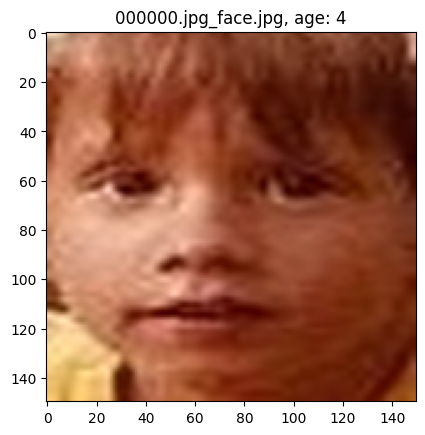

In [112]:
path = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_train/'
ix=0
shape = (150,150)
im = imread(os.path.join(path,image_name_face[ix]))
im = resize_image(im)


print(im.shape, im.dtype)
print(np.min(im), np.max(im))
plt.imshow(im)
plt.title(f"{image_name_face[ix]}, age: {ds_real_age[ix]}")
plt.show()

001763.jpg_face.jpg
000891.jpg_face.jpg
000628.jpg_face.jpg
001125.jpg_face.jpg
003611.jpg_face.jpg
002250.jpg_face.jpg
001719.jpg_face.jpg
000046.jpg_face.jpg
000837.jpg_face.jpg
000062.jpg_face.jpg
003275.jpg_face.jpg
000569.jpg_face.jpg
002633.jpg_face.jpg
000639.jpg_face.jpg
001843.jpg_face.jpg
003164.jpg_face.jpg
002158.jpg_face.jpg
003219.jpg_face.jpg


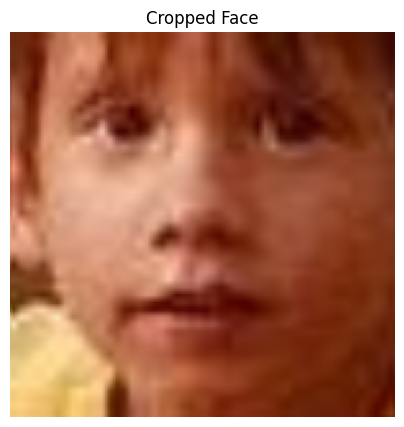

(150, 150, 3)


In [30]:
image = face_recognition.load_image_file(os.path.join(path,image_name_face[ix]))
face_locations = face_recognition.face_locations(image)

if face_locations:
    # Take the first face location
    first_face_location = face_locations[0]

    # Adjust the crop to make it wider
    crop_margin = 0 # You can change this value to increase or decrease the width

    # Get the coordinates of the first face
    top, right, bottom, left = first_face_location

    # Expand the crop area by the crop_margin
    # left = max(0, left - crop_margin)  # Ensure the crop doesn't go out of bounds
    # right = min(image.shape[1], right + crop_margin)  # Ensure the crop doesn't go out of bounds
    # top = max(0, top - 4*crop_margin)  # Optional: to make the crop taller

    # Crop the face from the image
    face_image = resize(image[top:bottom, left:right], (150,150)) #

    # Display the cropped face using matplotlib
    plt.figure(figsize=(5, 5))
    plt.imshow(face_image)
    plt.axis('off')  # Hide axes
    plt.title("Cropped Face")
    plt.show()
else:
    print("No faces found in the image.")


print(face_image.shape)

# Load the dataset in batches

In [31]:
# Load the dataset in batches for efficiency
def random_batch_generator(image_names, real_ages, batch_size, path, target_size=(150, 150)):
    dataset_size = len(image_names)
    while True:
        batch_indices = random.sample(range(dataset_size), batch_size)  # Randomly select batch indices
        images, ages = [], []
        
        for i in batch_indices:
            # Load and resize the image
            im = resize(imread(os.path.join(path, image_names[i])), target_size)
            images.append(im)
            ages.append(real_ages[i])

        yield np.array(images), np.array(ages)  # Return a batch of images and corresponding ages

In [32]:
# Usage example:
random_gen = random_batch_generator(image_name_face, ds_real_age, batch_size=32, path=path)

# Fetch a random batch
images_batch, ages_batch = next(random_gen)

# Check the shapes
print(images_batch.shape)  # Output: (32, 150, 150, 3)
print(ages_batch.shape)    # Output: (32,)

(32, 150, 150, 3)
(32,)


(3920,)


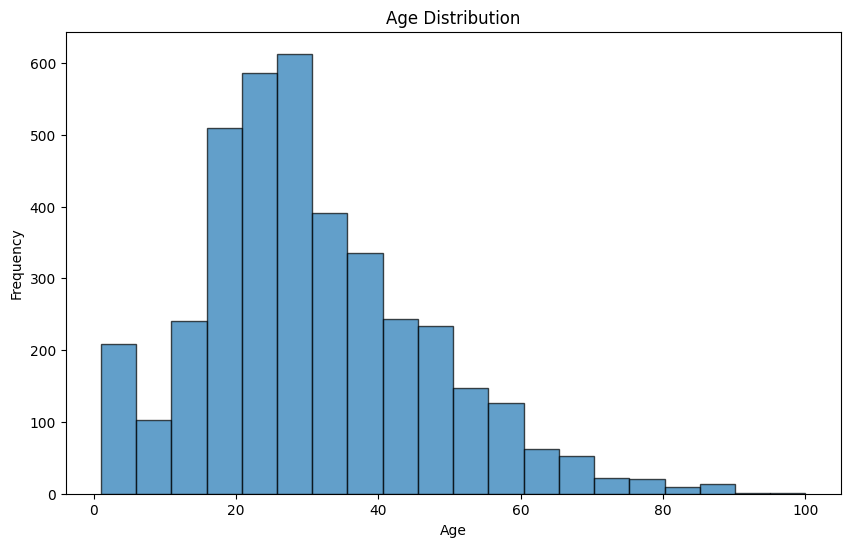

Percentiles: [  1.  20.  28.  40. 100.]


In [9]:
# Lets plot a histogram of the ages
print(ds_real_age.shape)

ages = df.iloc[:, -1]  # Get the last age

# Plot the histogram to visualize the age distribution
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=20, edgecolor='k', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Calculate the percentiles to help decide bin ranges
percentiles = np.percentile(ages, [0, 25, 50, 75, 100])
print(f"Percentiles: {percentiles}")

# Define bins based on percentiles
bins = [0, 18, percentiles[2], percentiles[3], np.max(ages)]
labels = [0, 1, 2, 3]  # Age bins

# Bin the ages into these ranges
age_bins = pd.cut(ages, bins=bins, labels=labels, include_lowest=True)

# Check the bin distribution
print(age_bins.value_counts())

Percentiles: [  1.  20.  28.  40. 100.]
real_age
1    1167
2     971
3     934
0     848
Name: count, dtype: int64


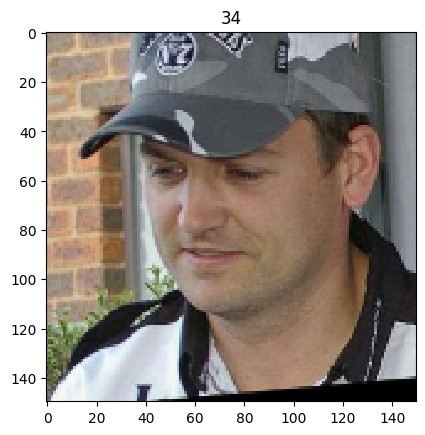

In [34]:
ix = 1
plt.imshow(images_batch[ix], interpolation='nearest')
plt.title(ages_batch[ix])
plt.show()

# Normalise image

 Shape after normalisation : (150, 150, 3) uint8
 Min / Max after normalisation : 0 255
 Shape after hrescale : (150, 150)


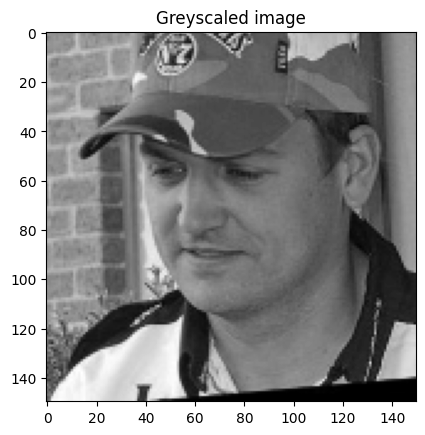

In [35]:
# Normalise to between 0-255 for use in cv2 functions
normalized_image = cv2.normalize(images_batch[ix], None, 0, 255, cv2.NORM_MINMAX)
# Change to unsigned 8bit integer so cv2 stops complaining
uint8_image = normalized_image.astype('uint8')
print(f" Shape after normalisation : {uint8_image.shape} {uint8_image.dtype}")
print(f" Min / Max after normalisation : {np.min(uint8_image)} {np.max(uint8_image)}")
grey_image = cv2.cvtColor(uint8_image, cv2.COLOR_BGR2GRAY)
print(f" Shape after hrescale : {grey_image.shape}")
plt.imshow(grey_image, cmap='grey')
plt.title('Greyscaled image')
plt.show()


Mean before equalizing histograms : 111.8692
Mean after equalizing histograms  : 126.34666666666666


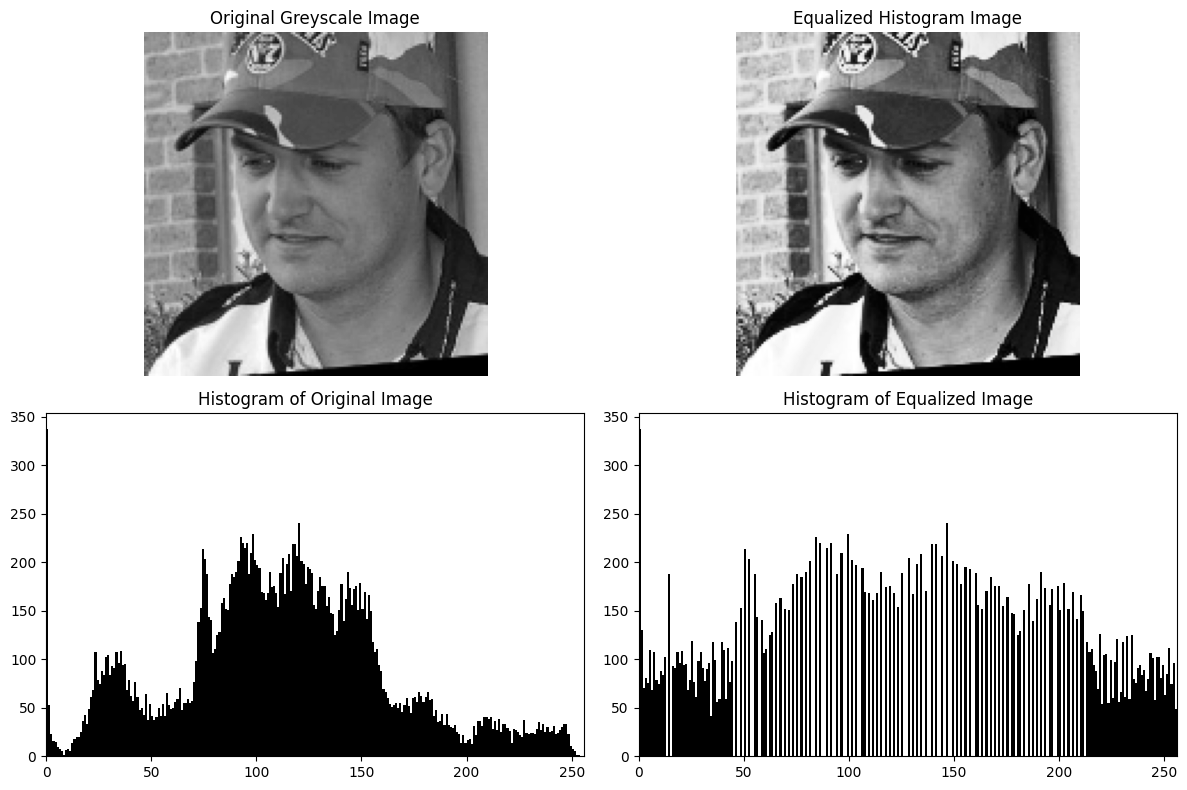

In [36]:
# Equalizing the histogram
equ = cv2.equalizeHist(grey_image)

# Display mean values
print(f"Mean before equalizing histograms : {np.mean(grey_image)}")
print(f"Mean after equalizing histograms  : {np.mean(equ)}")

# Create a figure with subplots: 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Display original greyscale image
axs[0, 0].imshow(grey_image, cmap='gray')
axs[0, 0].set_title('Original Greyscale Image')
axs[0, 0].axis('off')

# Display histogram of original greyscale image
axs[1, 0].hist(grey_image.ravel(), bins=256, range=[0, 256], color='black')
axs[1, 0].set_title('Histogram of Original Image')
axs[1, 0].set_xlim([0, 256])

# Display equalized image
axs[0, 1].imshow(equ, cmap='gray')
axs[0, 1].set_title('Equalized Histogram Image')
axs[0, 1].axis('off')

# Display histogram of equalized image
axs[1, 1].hist(equ.ravel(), bins=256, range=[0, 256], color='black')
axs[1, 1].set_title('Histogram of Equalized Image')
axs[1, 1].set_xlim([0, 256])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


# Feature Extraction

## Edge Detection

In [37]:
# from skimage import filters
# edges = filters.sobel(equ)
# plt.imshow(edges, cmap='grey')
# plt.title('Edges identified')
# plt.show()
# print(edges.shape)

 edges shape : (150, 150)
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0 255 ...   0   0   0]
 [  0   0 255 ...   0   0   0]
 [  0 255   0 ...   0   0   0]]


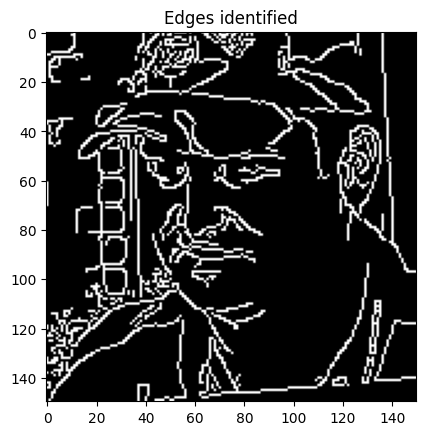

(22500,)


In [38]:
# Now we can extract the edges from the image
edge = cv2.Canny(equ, 150, 300) # The minVal and maxVal should be adjusted to suit best
print(f" edges shape : {edge.shape}")
print(edge)
plt.imshow(edge, cmap='grey')
plt.title('Edges identified')
plt.show()
flattened_edges = np.ndarray.flatten(edge)
print(flattened_edges.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


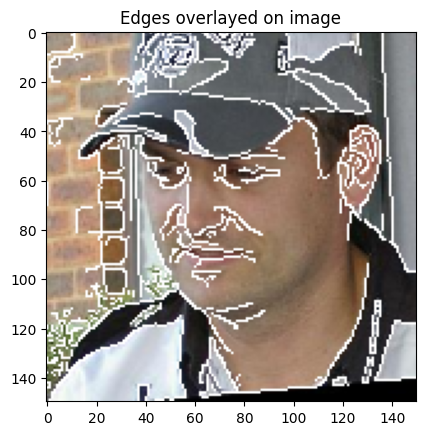

In [39]:
display_edges = np.copy(images_batch[ix])
display_edges[edge ==255]=(255, 255, 255)
plt.imshow(display_edges)
plt.title('Edges overlayed on image')
plt.show()

## Local Binary Pattern

(150, 150) 134217727.0


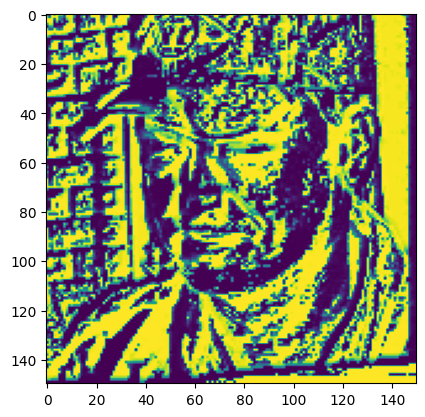

(22500,)


In [40]:
radius = 3
num_points = 9 * radius

image = equ
lbp = local_binary_pattern(grey_image, num_points, radius, method='default')
print(lbp.shape, np.max(lbp))
plt.imshow(lbp) 
plt.show()
print(np.ndarray.flatten(lbp).shape)

## Histogram of Oriented Gradients

fd shape: (4624,), HoG shape: (150, 150)


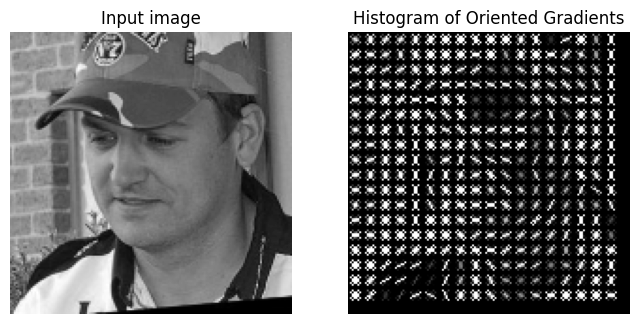

In [45]:
#creating hog features
fd, hog_image = hog(
    equ,
    orientations=4,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    feature_vector=True,
)

print(f"fd shape: {fd.shape}, HoG shape: {hog_image.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(grey_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()